# Demo: Part 3

This notebook is part 3 of a 3-part demonstration of the model, tested on a Windows 11 machine.

### Instructions:
1. **Setup**: Follow the instructions in [README.md](README.md) (also given in [demo_part1.ipynb](demo_part1.ipynb)) to:
   - Set up the required [Conda environments](README.md#setup).
   - Download all necessary [data and models](README.md#download-models-and-data).
   - Prepare codebase of the [submodule](README.md#prepare-codebase)  

2. **Preparation**: Complete the steps in [./RetrievalModel/demo_part2.ipynb](RetrievalModel/demo_part2.ipynb) before running this notebook. 

3. **Environment**: Use the `retrosub` conda virtual environment for this notebook. Refer to the [README.md](README.md) file for detailed instructions on setting up the required environments.  
 

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import json
import operator
import pickle
import random
from collections import Counter

from rdkit import Chem
from rdkit.Chem import Draw

from demo import (extract_all, load_retrieved_candidates,
                  load_sub_seq2seq_output, merge,
                  merge_predicted_frag_with_substructures,
                  prepaire_sub_seq2seq_input, rerank_candidates,
                  save_input_for_dual_encoder, save_input_for_subseq2seq,
                  view_sub_extractions)
from utils.smiles_utils import canonicalize_smiles, smi_tokenizer


In [4]:
# this file is a dictionary, key: target (reactants), value: source (all possible products)
# it is generated on the train and val data by 'data_utils/collect_reaction.py', and is used
# to filter substructures extracted from candidate reactants (target side) but not exists in
# the product molecules (source side). It means that the substructures shall also remain
# unchanged during the reaction from source (product of retrieved candidate reactants) to 
# target (retrieved candidate reactants). 
# load only for the first time
try:
    all_reaction_t2s
except NameError:
    all_reaction_t2s = pickle.load(open('data/uspto_full/reaction.pkl', 'rb'))

input_product_smiles: COC(=O)Cc1cc2ccc(F)cc2c(-c2ccc(S(C)(=O)=O)cn2)c1C
golden_reactants_smiles: COC(=O)Cc1cc2ccc(F)cc2c(B2OC(C)(C)C(C)(C)O2)c1C.CS(=O)(=O)c1ccc(Br)nc1


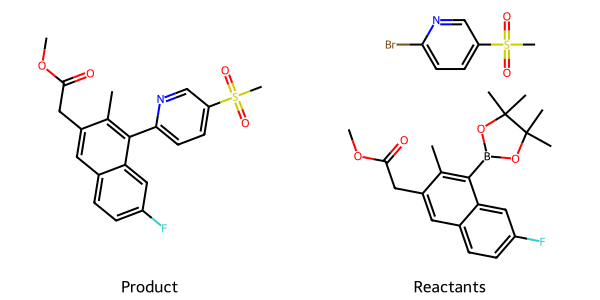

In [5]:

# we prepaire 200 samples in demo_data/test_cases.json, in which 's' is the source (product) and 't' is the target (reactant)
test_cases = json.load(open('demo_data/test_cases.json'))
# some typical cases in test_cases.json, change the value of test_case_idx below to view results
#   1 Suzuki-Miyaura Cross Coupling
#   2 Amide Condensation
#   5 SN2 Substitution
#   6 Ester Hydrolysis(Deprotection)
#  16 Sonogashira Cross Coupling
#  19 Nitro Reduction
#  22 Free Radical Halogenation
#  43 Nitrile Hydrolysis
#  56 Aldol Condensation
# 145 Sulphur Oxidation

# please change test_case_idx, or change the input below, to try other examples
test_case_idx = 1 # Suzuki-Miyaura Cross Coupling

input_product_smiles, golden_reactants_smiles = test_cases[test_case_idx]['s'], test_cases[test_case_idx]['t']

# the dual encoder was trained on canonicalized SMILES
input_product_smiles = canonicalize_smiles(input_product_smiles)
golden_reactants_smiles = canonicalize_smiles(golden_reactants_smiles)
print(f'input_product_smiles: {input_product_smiles}')
print(f'golden_reactants_smiles: {golden_reactants_smiles}')
Draw.MolsToGridImage([Chem.MolFromSmiles(input_product_smiles), Chem.MolFromSmiles(golden_reactants_smiles)], \
    legends=['Product', 'Reactants'],
    molsPerRow=2, subImgSize=(300, 300))

In [7]:
"""# the input of the dual encoder is tokenized SMILES of product
tokenized_product_smi = smi_tokenizer(input_product_smiles)
# save the input to file
save_input_for_dual_encoder(tokenized_product_smi)"""
print('tokenized_product_smi: ', input_product_smiles)

tokenized_product_smi:  COC(=O)Cc1cc2ccc(F)cc2c(-c2ccc(S(C)(=O)=O)cn2)c1C


In [6]:
# view the script to retrieve reactions top 20 candidates
# the input file is 'test_input_dual_encoder.txt'
# the output file is 'test_input_dual_encoder.top20.txt'

#Using python:
with open("demo_data/test_input_dual_encoder.txt", "r") as file:
    print(file.read())

C O C ( = O ) C c 1 c c 2 c c c ( F ) c c 2 c ( - c 2 c c c ( S ( C ) ( = O ) = O ) c n 2 ) c 1 C	TGT_PLACEHOLDER


In [10]:
# view output of dual encoder (all content in 1 line)
# tokenized_product_SMILES \TAB TGT_PLACEHOLDER \TAB retrieved_candidate_SMILES_1 \SPACE score_1 \SPACE retrieved_candidate_SMILES_2 \SPACE score_2	...
# \TAB => \t , \SPACE=> space, TGT_PLACEHOLDER is a placeholder which is not used

with open("demo_data/test_input_dual_encoder.top20.txt", "r") as file:
    print(file.read())

C O C ( = O ) C c 1 c c 2 c c c ( F ) c c 2 c ( - c 2 c c c ( S ( C ) ( = O ) = O ) c n 2 ) c 1 C	TGT_PLACEHOLDER	C O C ( = O ) C c 1 c c 2 c c c ( F ) c c 2 c ( O S ( = O ) ( = O ) C ( F ) ( F ) F ) c 1 C . C S ( = O ) ( = O ) c 1 c c c ( B ( O ) O ) c c 1	0.9396535754203796	C O C ( = O ) C c 1 c c 2 c c c ( F ) c c 2 c ( O S ( = O ) ( = O ) C ( F ) ( F ) F ) c 1 C . C c 1 c c c c c 1 S ( = O ) ( = O ) c 1 c c c ( B 2 O C ( C ) ( C ) C ( C ) ( C ) O 2 ) c c 1	0.9394717216491699	C C S ( = O ) ( = O ) c 1 c c c ( Br ) n c 1 . C O C ( = O ) C c 1 c c ( O ) c 2 c c ( F ) c c c 2 c 1 C	0.9388871192932129	C O C ( = O ) C c 1 c c 2 c c c ( F ) c c 2 c ( - c 2 c c c ( S ( C ) ( = O ) = O ) c n 2 ) c 1 C	0.9384120106697083	C C S ( = O ) ( = O ) c 1 c c c ( Br ) n c 1 . C O C ( = O ) C c 1 c c 2 c c c ( F ) c c 2 c ( O ) c 1 F	0.9382520914077759	C O C ( = O ) C c 1 c c 2 c c c ( F ) c c 2 c ( O S ( = O ) ( = O ) C ( F ) ( F ) F ) c 1 C . C c 1 c c c ( C B 2 O C ( C ) ( C ) C ( C ) ( C ) O 2 ) c

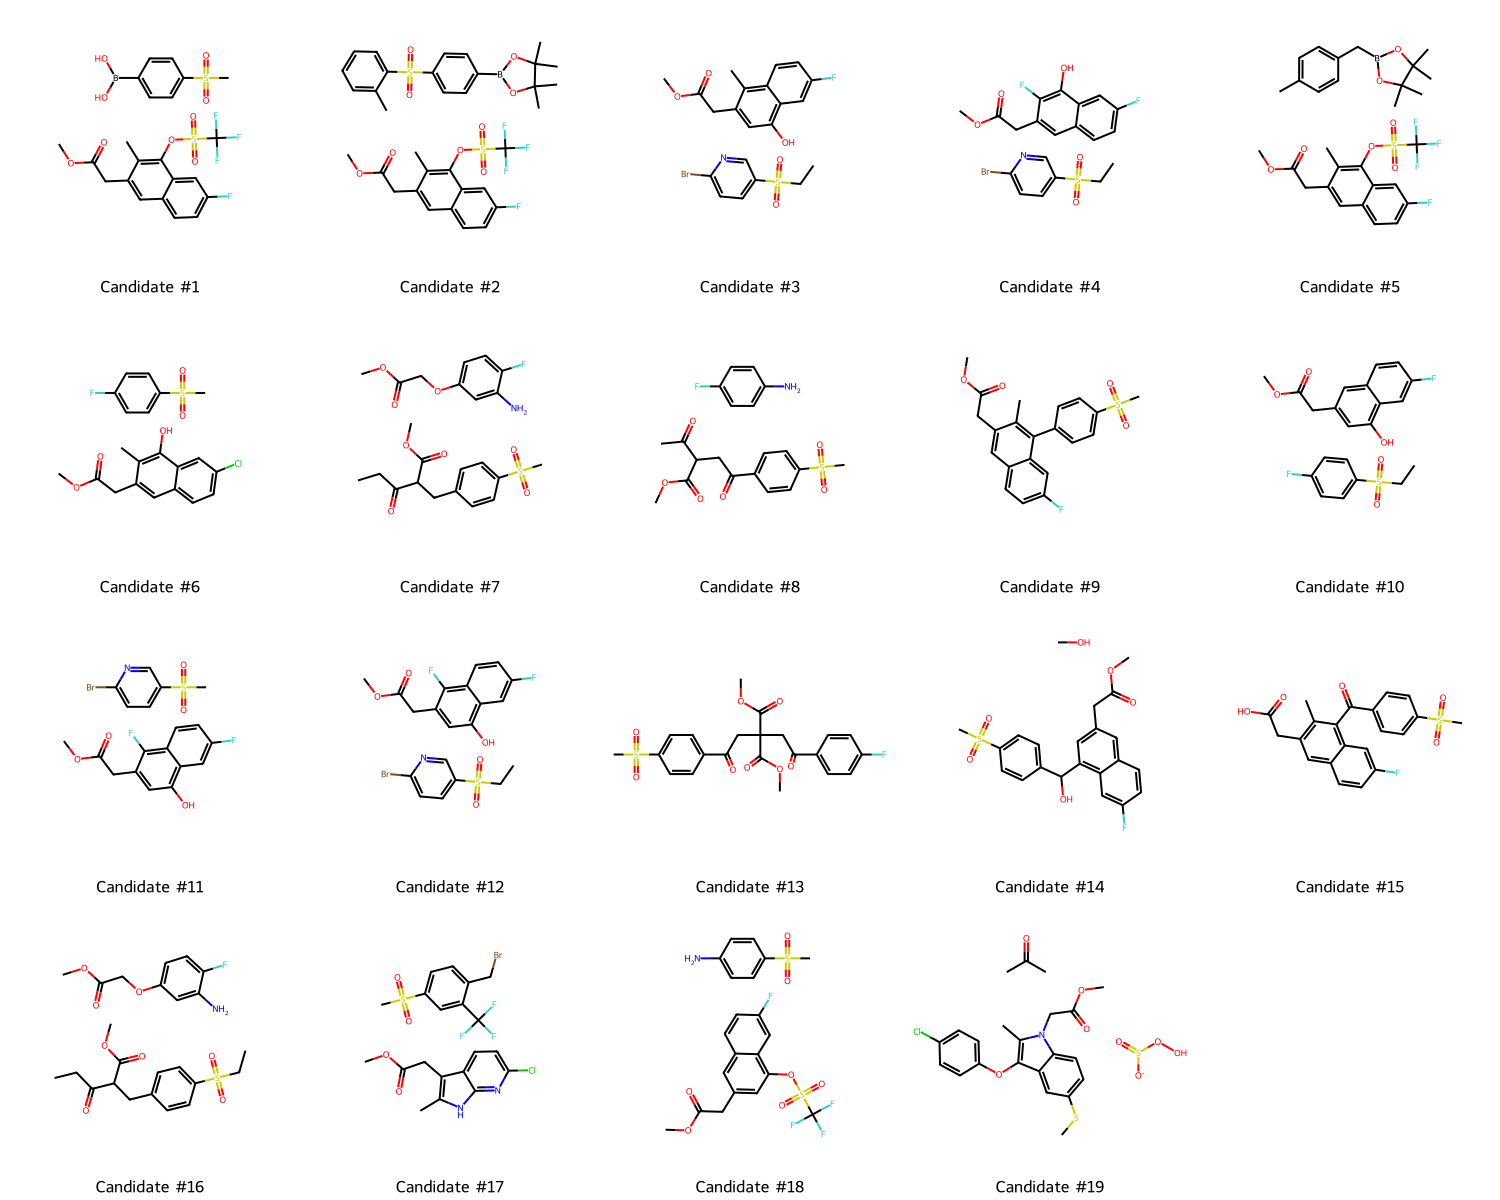

In [11]:
# the total number of candidates might be 19, as we remove the input_product_smiles from retrieved candidates if exists
candidates = load_retrieved_candidates(input_product_smiles)
Draw.MolsToGridImage([Chem.MolFromSmiles(cand) for cand in candidates], molsPerRow=5, subImgSize=(300, 300), legends= [f'Candidate #{i+1}' for i in range(len(candidates))])

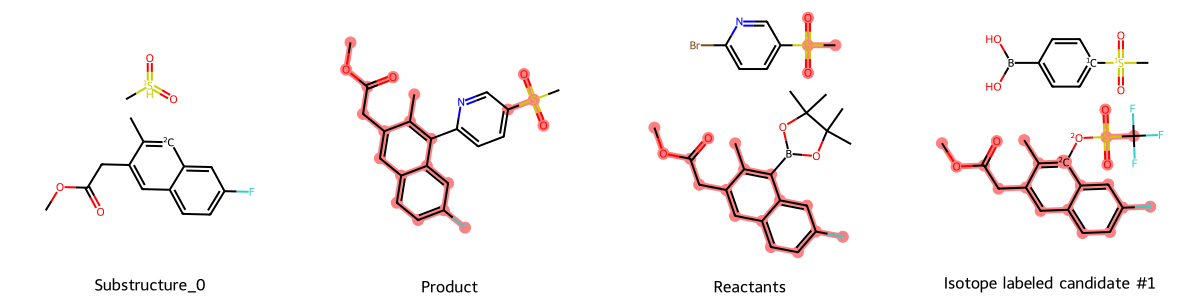

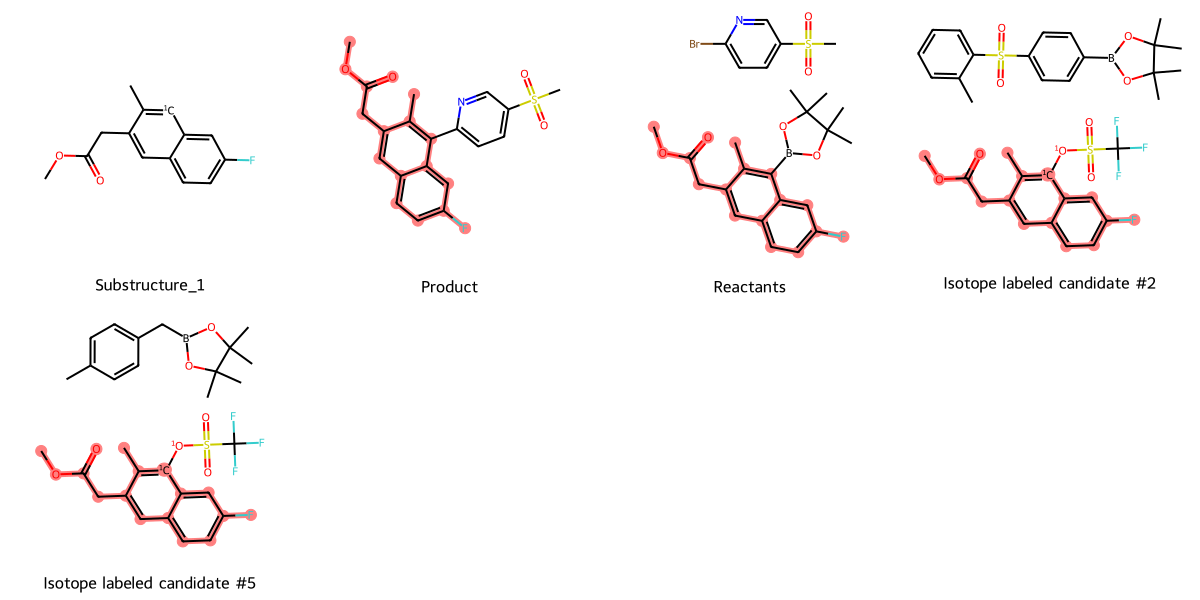

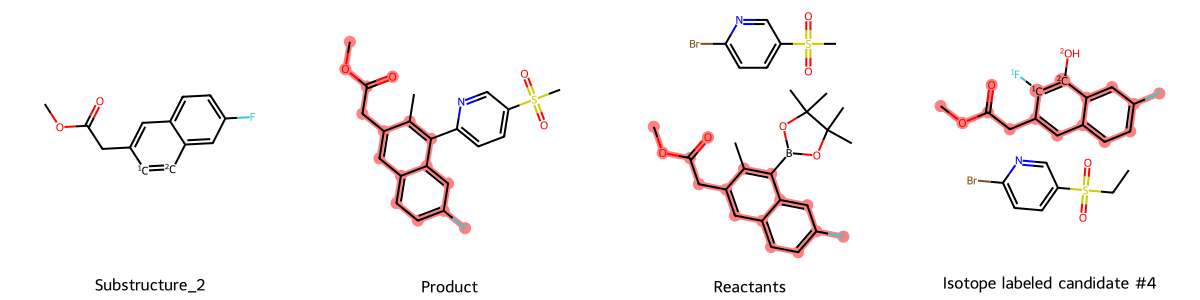

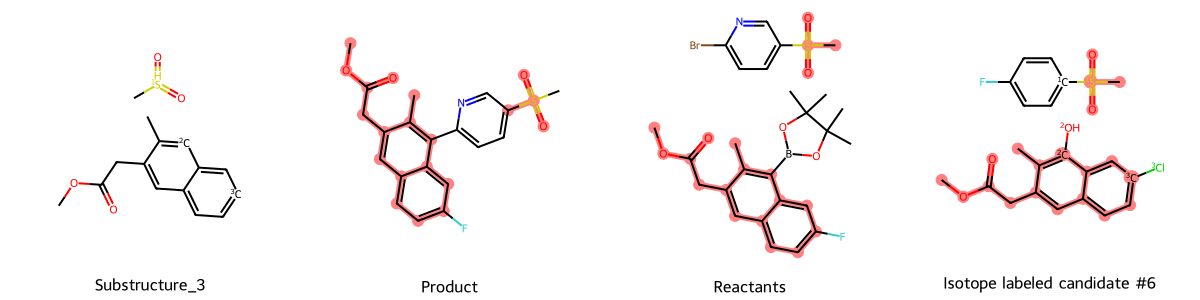

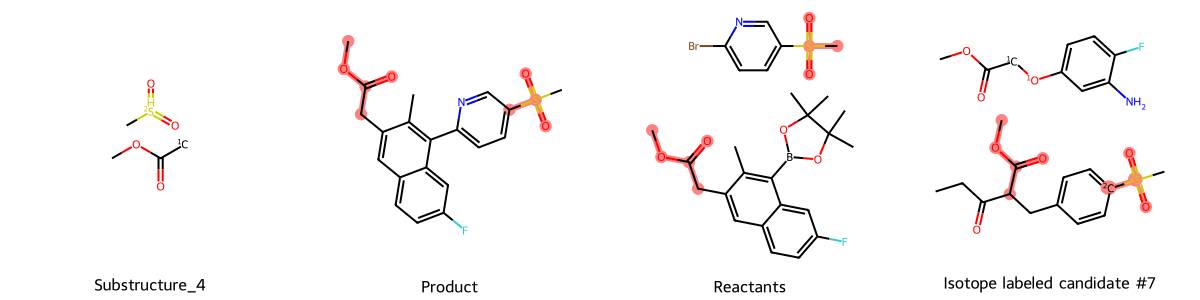

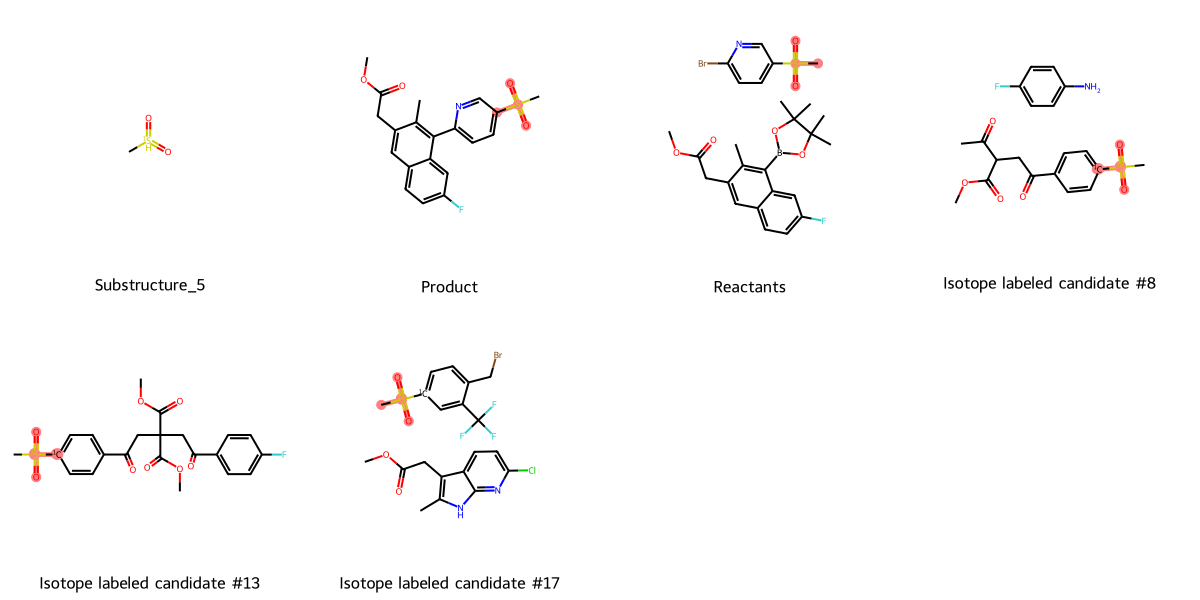

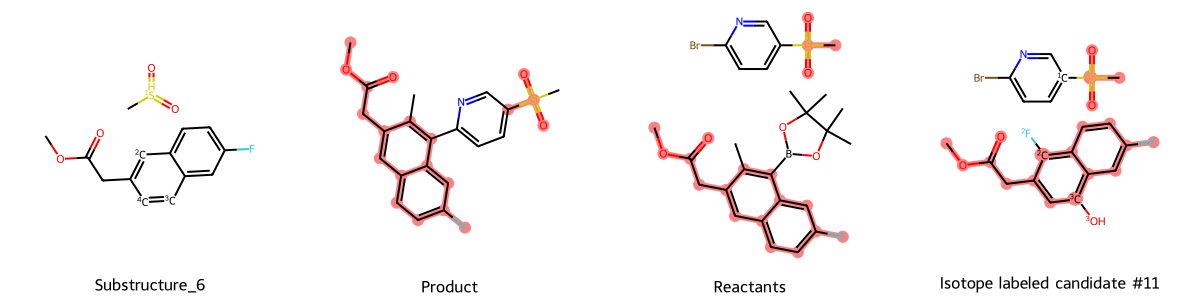

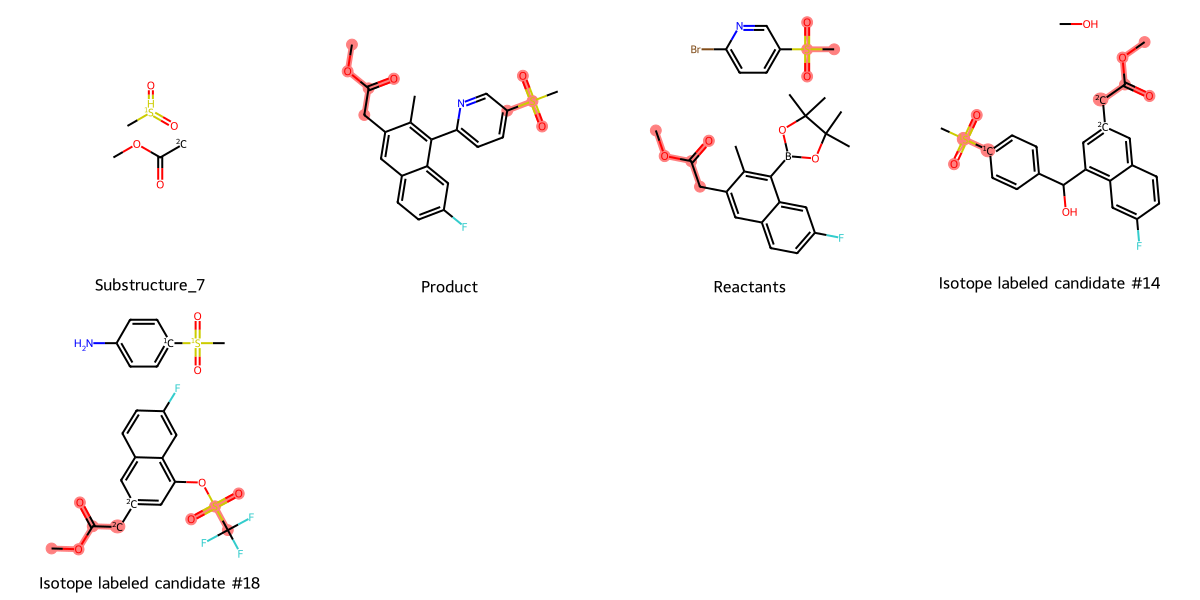

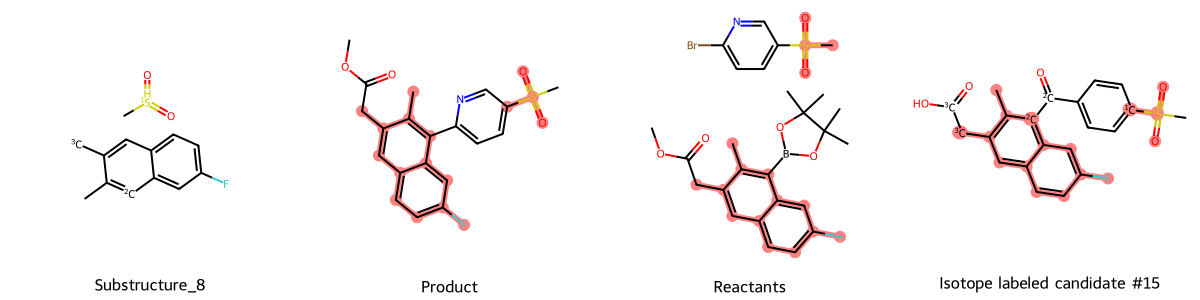

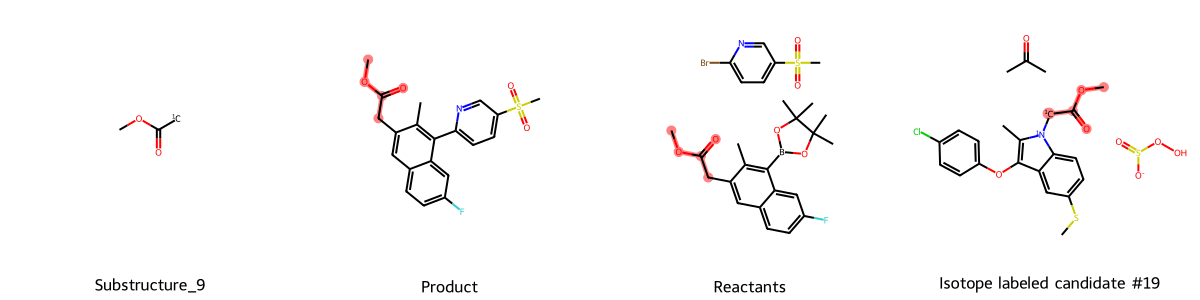

In [12]:
# do substructure extraction from all retrieved candidates
extraction_results = extract_all(input_product_smiles, candidates, all_reaction_t2s, min_count=5)

# view extraction results
# NOTE1: some isotope numbers in substructure are not shown in the labeled candidate reactants,
# because the product molecules of those candidates have none-substrcucture neighbour atoms, 
# which are not shown here.
# NOTE2: some substructures differ only in the isotope numbers, we consider them as different
# substructures.
view_sub_extractions(input_product_smiles, golden_reactants_smiles, candidates, extraction_results)
   

In [13]:
# prepare input for substructure-level sequence to sequence model inference
# subs_for_merge will be used to merge substructure with fragments
input_smiles, subs_for_merge = prepaire_sub_seq2seq_input(extraction_results)

# save the input 
save_input_for_subseq2seq(input_smiles)

# view random 5 samples
print('\n'.join(random.sample(input_smiles, 5)))

[2SH] ( = O ) ( C ) = O . [1CH3] C ( O C ) = O | c 1 c ( c c c 2 c 1 c ( - c 1 c c [2cH] c n 1 ) c ( C ) [1cH] c 2 ) F
C [1SH] ( = O ) = O | C O C ( = O ) C c 1 c c 2 c c c ( F ) c c 2 c ( - c 2 c c [1cH] c n 2 ) c 1 C
C O C ( [2CH3] ) = O . C [1SH] ( = O ) = O | C c 1 [2cH] c c 2 c c c ( F ) c c 2 c 1 - c 1 c c [1cH] c n 1
C [1SH] ( = O ) = O . O = C ( [2CH3] ) O C | F c 1 c c 2 c ( c c 1 ) c [2cH] c ( c 2 - c 1 c c [1cH] c n 1 ) C
C O C ( [1CH3] ) = O . C [2SH] ( = O ) = O | C c 1 [1cH] c c 2 c c c ( F ) c c 2 c 1 - c 1 c c [2cH] c n 1


In [25]:
# view the script for inference
# Note: n_best is set to 10
with open("demo_data/subseq2seq.sh", "r") as file:
    print(file.read())

print('\n\n\n############### Run Inference ###############\n\n\n')

#linux:

# on CPU, batch_size 30
#! bash demo_data/subseq2seq.sh -1 30
# on GPU, batch_size 30
# ! bash demo_data/subseq2seq.sh 0 30

# For windows:
# on CPU, batch_size 30
!demo_data\subseq2seq.bat -1 30
# on GPU, batch_size 30
#!demo_data\ubseq2seq.bat 0 30

#!/bin/bash

gpu=$1
bz=$2

# current directory
CURRENT_DIR=$PWD
# script directory
SCRIPT_DIR=$(cd "$(dirname "${BASH_SOURCE[0]}")" &> /dev/null && pwd)
# change to script directory
cd $SCRIPT_DIR

python ../MolecularTransformer/translate.py \
            -model ../models/uspto_full_retrosub.pt \
            -src test_input_seq2seq.txt \
            -output predict_output.txt \
            -batch_size $bz -replace_unk -max_length 200 -fast -n_best 10 -beam_size 10  -gpu $gpu
cd $CURRENT_DIR



############### Run Inference ###############



PRED AVG SCORE: -0.0126, PRED PPL: 1.0127


c:\Users\fahim\anaconda3\envs\retrosub\lib\site-packages\torchtext\data\field.py:323: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  var = torch.tensor(arr, dtype=self.dtype, device=device)


In [26]:
# load model output, a list of tuple (rank, predicted_fragments)
rank_pred_frag_list = load_sub_seq2seq_output()
rank_pred_frag_list[:5]

[(0, 'CC1(C)O[2BH]OC1(C)C.Clc1cc[1cH]cn1'),
 (1, 'Brc1cc[1cH]cn1.CC1(C)O[2BH]OC1(C)C'),
 (2, 'Clc1cc[1cH]cn1.O[2BH]O'),
 (3, 'Clc1cc[1cH]cn1.[2BrH]'),
 (4, 'Brc1c[1cH]ccn1.CC1(C)O[2BH]OC1(C)C')]

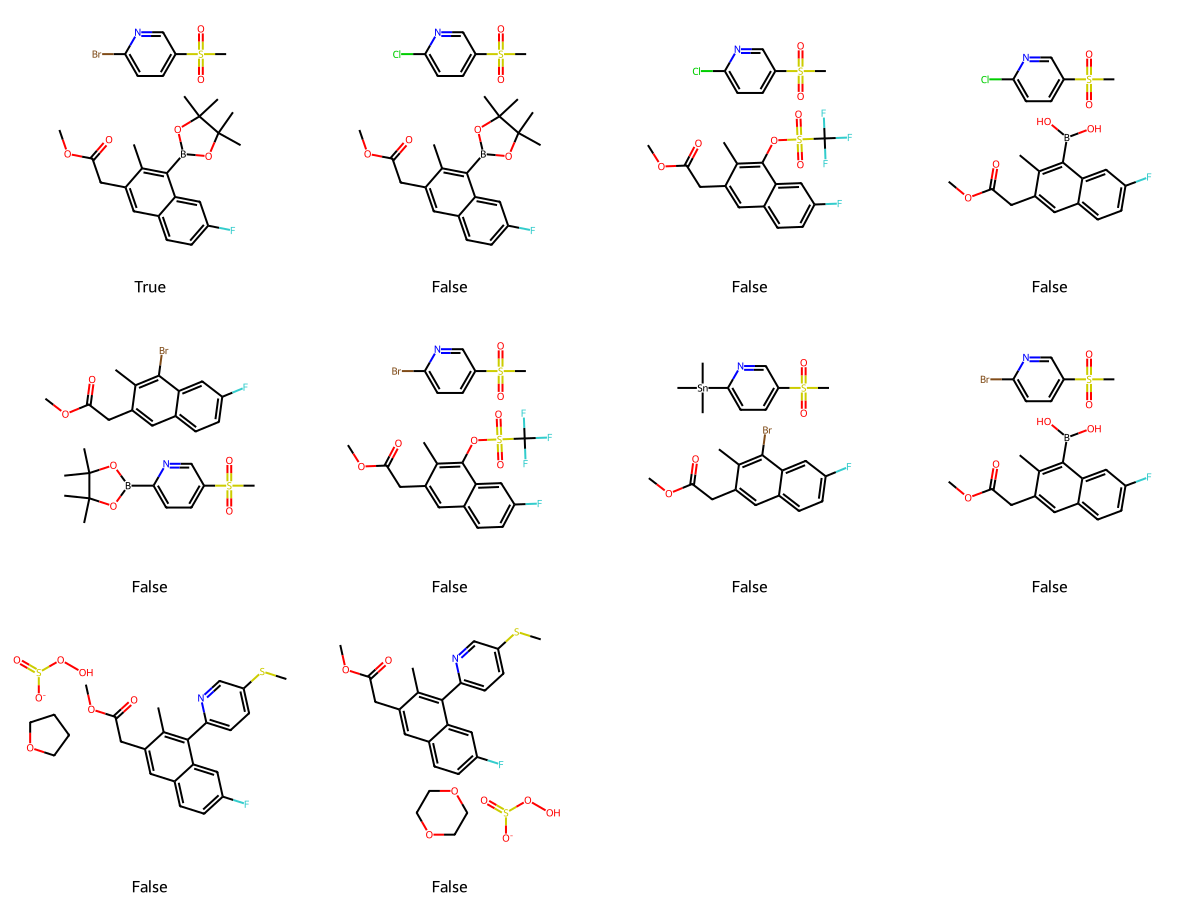

In [27]:
# merge predicted fragments with substructures
# predict2sub_rank is a dictionary
#       key: SMILES of merged reactants
#       value: a list of tuple (SMILES of substructure, PLACEHOLDER, rank) 
# we will extract features from value for reranking. 
# all_predictions is a list of tuple (SMILES of merged reactants, flag) and flag = [True, False]
# there might have duplicate entries in all_predictions, because different substructures might have same prediction.
pred2sub_rank, all_predictions = merge_predicted_frag_with_substructures(rank_pred_frag_list, subs_for_merge, golden_reactants_smiles)

# view most frequent entries in all_predictions
predicted_smi2label_list = [ele[0] for ele in Counter(all_predictions).most_common(10)]
Draw.MolsToGridImage([Chem.MolFromSmiles(ele[0]) for ele in predicted_smi2label_list], legends=[str(ele[1]) for ele in predicted_smi2label_list], molsPerRow=4, subImgSize=(300, 300))

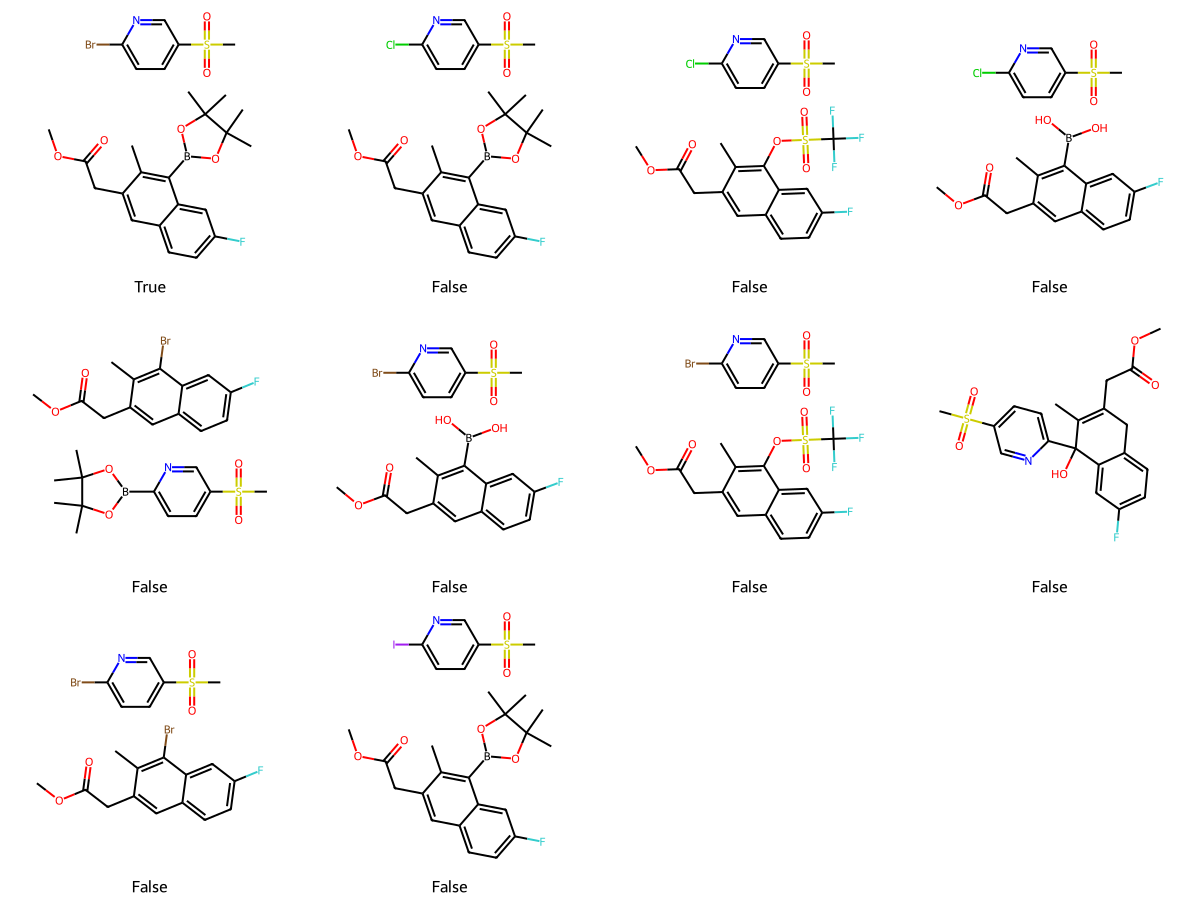

In [28]:
# rerank
pred_smi2score = rerank_candidates(input_product_smiles, pred2sub_rank, all_predictions)
d = sorted(pred_smi2score.items(), key=operator.itemgetter(1),reverse=True)
reranked_predicted_smi2label_list = [ele[0] for ele in d[:10]]
Draw.MolsToGridImage([Chem.MolFromSmiles(ele[0]) for ele in reranked_predicted_smi2label_list], legends=[str(ele[1]) for ele in reranked_predicted_smi2label_list], molsPerRow=4, subImgSize=(300, 300))